# Import Library


In [2]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import random
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import wandb
from datasets import load_dataset
from collections import Counter

In [3]:
dataset= load_dataset("garythung/trashnet", split="train")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

dataset-original.zip:   0%|          | 0.00/3.63G [00:00<?, ?B/s]

dataset-resized.zip:   0%|          | 0.00/42.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5054 [00:00<?, ? examples/s]

In [4]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 5054
})

In [5]:
dataset.features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'], id=None)}

# Exploratory Image Analysis (EDA)

## Show some of the sample images

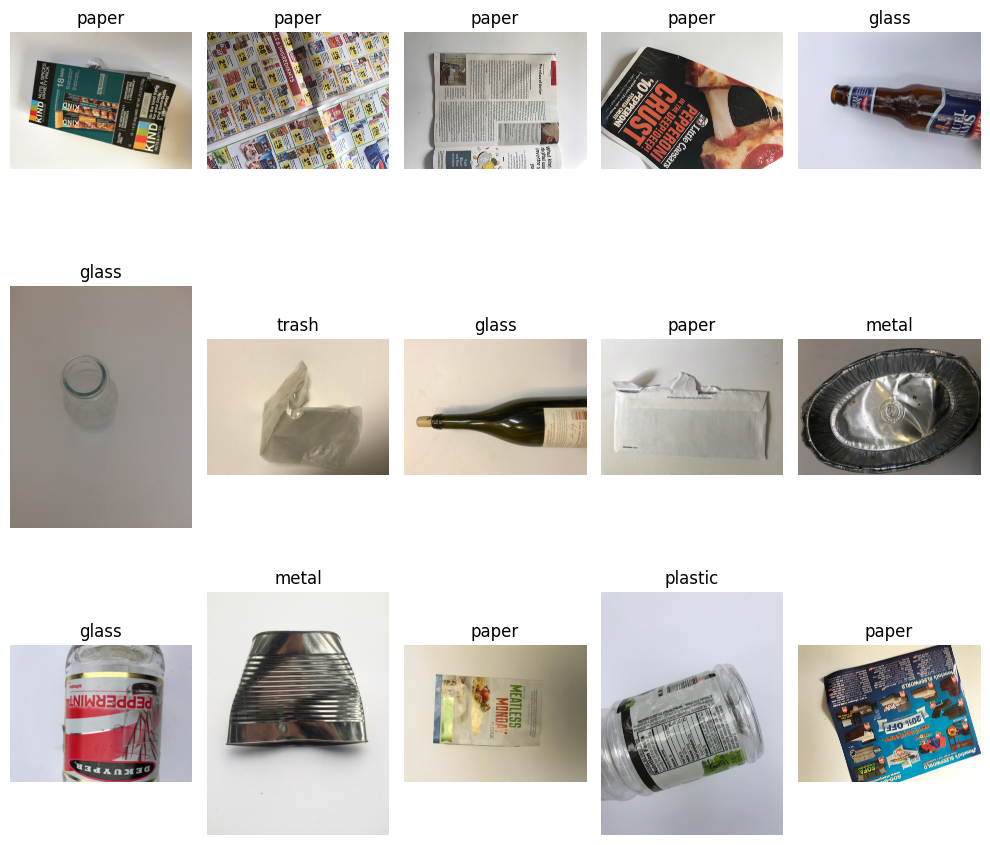

In [6]:
def display_random_images(dataset, num_images=15):
  """
  Display random images from the dataset.

  Args:
    dataset: The dataset object.
    num_images: The number of images to display.
  """
  num_rows= 3
  num_cols= num_images // num_rows

  indices = random.sample(range(len(dataset)), num_images)

  fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

  label_mapping = {
      0: 'cardboard',
      1: 'glass',
      2: 'metal',
      3: 'paper',
      4: 'plastic',
      5: 'trash'
  }

  for idx, sample_idx in enumerate(indices):
    row = idx // num_cols
    col = idx % num_cols

    sample = dataset[sample_idx]
    img = sample["image"]
    label = label_mapping[sample["label"]]

    axes[row, col].imshow(img)
    axes[row, col].set_title(label)
    axes[row, col].axis('off')

  plt.tight_layout()
  plt.show()


display_random_images(dataset)

## Label Distribution

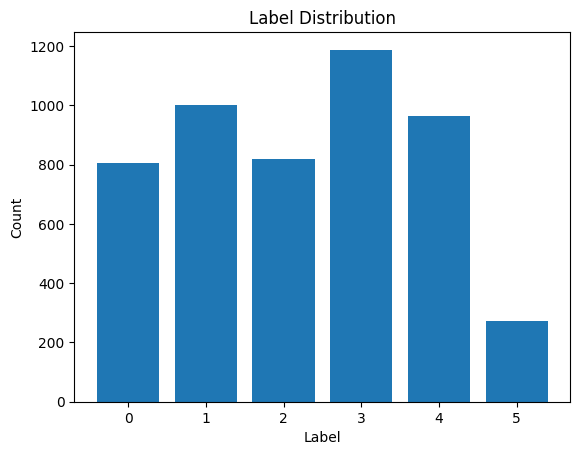

In [7]:
count_label = Counter(dataset['label'])

fig, ax = plt.subplots()
ax.bar(count_label.keys(), count_label.values())
ax.set_title('Label Distribution')
ax.set_xlabel('Label')
ax.set_ylabel('Count')
plt.show()

# Data Preparation

## Convert data to tensor

In [8]:
transformers = transforms.Compose([
    transforms.Resize((224, 224)),

    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),

    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [9]:
class TrashDataset:
  def __init__(self, dataset, transform=None):
    self.dataset = dataset
    self.transform = transform

  def __getitem__(self, idx):
    sample = self.dataset[idx]
    image = sample['image']
    label = sample['label']

    if self.transform:
      image = self.transform(image)

    return image, label

  def __len__(self):
    return len(self.dataset)


In [10]:
trash_dataset = TrashDataset(dataset, transformers)

In [11]:
BATCH_SIZE = 32
train_loader = DataLoader(trash_dataset, batch_size=BATCH_SIZE, shuffle=True)

## Split Dataset (70% Training, 20% Validation, 10% Test)

In [12]:
total_size = len(trash_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

train_data, val_data, test_data = random_split(
    trash_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

In [13]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print(f"Number of Training data: {len(train_data)}")
print(f"Number of Validation data: {len(val_data)}")
print(f"Number of Test data: {len(test_data)}")

Number of Training data: 3537
Number of Validation data: 1010
Number of Test data: 507


# Modelling

In [14]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [15]:
wandb.init(
    project="cnn-trash-classicifations",

    config={
    "batch_size" : 32,
    "learning_rate": 0.0001,
    "architecture": "CNN",
    "epochs": 10,
    "num_classes": 6,
    }
)

wandb: Currently logged in as: althariqfairuz273 (althariqfairuz273-institut-teknologi-bandung). Use `wandb login --relogin` to force relogin


In [16]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Conv layer
        self.conv1 = nn.Conv2d(3, 32, kernel_size= 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size= 5)
        self.conv3 = nn.Conv2d(64, 128, kernel_size= 5)
        self.dropout = nn.Dropout(0.25)

        # Flattened size
        self.flat_size = 128 * 24 * 24

        # Dense layer
        self.fc1 = nn.Linear(self.flat_size, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, self.flat_size)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [17]:
model = CNN()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [18]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 220, 220]           2,432
         MaxPool2d-2         [-1, 32, 110, 110]               0
            Conv2d-3         [-1, 64, 106, 106]          51,264
         MaxPool2d-4           [-1, 64, 53, 53]               0
            Conv2d-5          [-1, 128, 49, 49]         204,928
         MaxPool2d-6          [-1, 128, 24, 24]               0
            Linear-7                  [-1, 128]       9,437,312
           Dropout-8                  [-1, 128]               0
            Linear-9                   [-1, 32]           4,128
          Dropout-10                   [-1, 32]               0
           Linear-11                    [-1, 6]             198
Total params: 9,700,262
Trainable params: 9,700,262
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forw

In [19]:
def evaluate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return val_loss / len(val_loader), correct / total


def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, patience):
   model.train()
   best_val_loss = float('inf')
   patience_counter = 0

   for epoch in tqdm(range(epochs), desc='Epochs'):
       running_loss = 0.0
       correct = total = 0

       for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False):
           inputs, labels = inputs.to(device), labels.to(device)
           optimizer.zero_grad()
           outputs = model(inputs)
           loss = criterion(outputs, labels)
           loss.backward()
           optimizer.step()

           running_loss += loss.item()
           _, predicted = torch.max(outputs, 1)
           total += labels.size(0)
           correct += (predicted == labels).sum().item()

       train_loss = running_loss / len(train_loader)
       train_acc = correct / total
       val_loss, val_acc = evaluate_model(model, val_loader, criterion)

       print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
       print(f"Epoch {epoch+1}/{epochs}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

       if val_loss < best_val_loss:
           best_val_loss = val_loss
           patience_counter = 0
           torch.save(model.state_dict(), 'best_model.pth')
       else:
           patience_counter += 1
           if patience_counter >= patience:
               print(f"No improvements detected after {patience_counter} epochs, stopping training process...")
               break

       wandb.log({
           "train_loss": train_loss,
           "train_acc": train_acc,
           "val_loss": val_loss,
           "val_acc": val_acc,
           "epoch": epoch + 1
       })

In [20]:
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10, patience=3)

Epochs:  10%|█         | 1/10 [10:39<1:35:59, 640.00s/it]

Epoch 1/10, Train Loss: 1.5800, Train Acc: 0.3438
Epoch 1/10, Val Loss: 1.4252, Val Acc: 0.4208



Epochs:  20%|██        | 2/10 [21:18<1:25:14, 639.31s/it]

Epoch 2/10, Train Loss: 1.2698, Train Acc: 0.5069
Epoch 2/10, Val Loss: 1.2472, Val Acc: 0.5158



Epochs:  30%|███       | 3/10 [31:58<1:14:35, 639.29s/it]

Epoch 3/10, Train Loss: 1.1574, Train Acc: 0.5567
Epoch 3/10, Val Loss: 1.2147, Val Acc: 0.5337



Epochs:  40%|████      | 4/10 [42:35<1:03:51, 638.53s/it]

Epoch 4/10, Train Loss: 1.0801, Train Acc: 0.5895
Epoch 4/10, Val Loss: 1.1560, Val Acc: 0.5653



Epochs:  50%|█████     | 5/10 [53:12<53:10, 638.11s/it]  

Epoch 5/10, Train Loss: 1.0121, Train Acc: 0.6175
Epoch 5/10, Val Loss: 1.1041, Val Acc: 0.5842



Epochs:  60%|██████    | 6/10 [1:03:52<42:35, 638.77s/it]

Epoch 6/10, Train Loss: 0.9615, Train Acc: 0.6344
Epoch 6/10, Val Loss: 1.0797, Val Acc: 0.5802



Epochs:  70%|███████   | 7/10 [1:14:26<31:51, 637.20s/it]

Epoch 7/10, Train Loss: 0.9134, Train Acc: 0.6534
Epoch 7/10, Val Loss: 1.0019, Val Acc: 0.6317



Epochs:  80%|████████  | 8/10 [1:25:01<21:12, 636.48s/it]

Epoch 8/10, Train Loss: 0.8519, Train Acc: 0.6839
Epoch 8/10, Val Loss: 0.9742, Val Acc: 0.6475



Epochs:  90%|█████████ | 9/10 [1:35:35<10:35, 635.75s/it]

Epoch 9/10, Train Loss: 0.7741, Train Acc: 0.7128
Epoch 9/10, Val Loss: 0.9516, Val Acc: 0.6366



Epochs: 100%|██████████| 10/10 [1:46:12<00:00, 637.21s/it]

Epoch 10/10, Train Loss: 0.7507, Train Acc: 0.7243
Epoch 10/10, Val Loss: 0.9611, Val Acc: 0.6564


In [23]:
def test_model(model_path, test_loader, criterion, device):
   # Load model
   model = CNN()
   model.load_state_dict(torch.load(model_path))
   model.to(device)
   model.eval()

   # Test metrics
   test_loss = 0.0
   correct = total = 0
   all_preds = []
   all_labels = []

   with torch.no_grad():
       for inputs, labels in test_loader:
           inputs, labels = inputs.to(device), labels.to(device)
           outputs = model(inputs)
           test_loss += criterion(outputs, labels).item()
           _, predicted = torch.max(outputs, 1)
           total += labels.size(0)
           correct += (predicted == labels).sum().item()

           all_preds.extend(predicted.cpu().numpy())
           all_labels.extend(labels.cpu().numpy())

   # Confusion matrix
   cm = confusion_matrix(all_labels, all_preds)
   plt.figure(figsize=(10,8))
   sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
   plt.title('Test Set Confusion Matrix')
   plt.ylabel('True Label')
   plt.xlabel('Predicted Label')
   wandb.log({"test_confusion_matrix": wandb.Image(plt)})
   plt.close()

   test_acc = correct / total
   test_loss = test_loss / len(test_loader)
   print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

   return test_loss, test_acc

test_loss, test_acc = test_model('/content/best_model.pth', test_loader, criterion, device)

<ipython-input-23-d113a0e8ff86>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Test Loss: 0.8571, Test Acc: 0.6568
